# Figure 3. LE step-by-step

This notebook is used to generate figure 3, which describes the different steps involved in the LE algorithm. 

The algorithm is demonstrated using one run from the multi-task dataset (Gonzalez-Castillo et al. 2015).

The code in this notebook contains portions of the SpectralEmbedding function from scikit-learn that implements the LE algorithm

At the end of this notebook, we also generate the embedding on a single step using the Spectral Embedding function to compare with the step-by-step approach.

All other notebooks rely on using the SpectralEmbedding interface from scikit-learn

In [1]:
import pandas as pd
import numpy as np
import os.path as osp
import networkx as nx

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.patches import Rectangle
import seaborn as sns
import hvplot.networkx as hvnx
import hvplot.pandas 
import plotly.express as px
import panel as pn
from IPython.display import Image
from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import kneighbors_graph
from sklearn.manifold._spectral_embedding import _set_diag, _deterministic_vector_sign_flip
from networkx import laplacian_matrix, degree
from scipy.sparse.csgraph import laplacian
from scipy.sparse.linalg import eigsh

In [2]:
from utils.basics import PRJ_DIR, task_cmap, task_cmap_caps

In [3]:
Distance_Function = 'euclidean' # Distance Function
knn               = 90          # Number of Neighbors for the N-Nearest Neighbors Step
drop_XXXX         = False       # Whether or not to include task-inhomogenous windows (e.g., those that contain data across tasks)
n_components      = 3           # Number of dimensions for the final embedding
norm_laplacian    = True        # Whether or not to use the normalized version of the laplacian (Sciki-learn used norm_laplacian = True)

***
### 1. Load representative SWC Matrix

First we load a tvFC matrix for a representative run from the multi-task dataset. Entries in this matrix are the Fisher's transform of the Pearson's correlation between windowed ROI timeseries.

In [4]:
swc_path    = osp.join(PRJ_DIR,'Resources','Figure03','swcZ_sbj06_ctask001_nroi0200_wl030_ws001.csv.gz')
swc         = pd.read_csv(swc_path, index_col=[0,1], header=0)
# Becuase pandas does not like duplicate column names, it automatically adds .1, .2, etc to the names. We delete those next
swc.columns = swc.columns.str.split('.').str[0]
win_labels  = swc.columns

In [5]:
print('++ INFO: Size of SWC dataframe is %d connections X %d windows.' % swc.shape)
swc.head(5)

++ INFO: Size of SWC dataframe is 12246 connections X 988 windows.


REST  REST  REST  REST  REST  REST  REST  REST  REST  REST  \
ROI001 ROI000  0.06  0.05  0.07  0.11  0.09  0.06  0.05  0.05  0.10  0.15   
ROI002 ROI000  0.42  0.39  0.39  0.38  0.36  0.38  0.37  0.27  0.25  0.33   
       ROI001  0.52  0.62  0.68  0.71  0.72  0.68  0.63  0.68  0.76  0.76   
ROI003 ROI000  0.41  0.42  0.41  0.42  0.46  0.47  0.45  0.39  0.40  0.52   
       ROI001  0.15  0.08 -0.02 -0.03  0.05  0.04 -0.08 -0.17 -0.13 -0.09   

               ...  VIDE  VIDE  VIDE  VIDE  VIDE  VIDE  VIDE  VIDE  VIDE  XXXX  
ROI001 ROI000  ... -0.12 -0.12 -0.15 -0.15 -0.15 -0.16 -0.18 -0.10  0.01  0.04  
ROI002 ROI000  ...  0.01 -0.10 -0.13 -0.08 -0.05 -0.05  0.04  0.12  0.08  0.07  
       ROI001  ... -0.17 -0.02  0.04 -0.11 -0.13 -0.10 -0.17 -0.16 -0.21 -0.25  
ROI003 ROI000  ... -0.54 -0.61 -0.60 -0.59 -0.57 -0.57 -0.53 -0.40 -0.36 -0.37  
       ROI001  ...  0.05  0.11  0.10  0.02  0.00  0.04  0.01 -0.01  0.00 -0.02  

[5 rows x 988 columns]

This code can be run in two ways:

* Using all available sliding windows (```drop_XXXX = False```)
* Using only task-homogenous windows (```drop_XXXX = True```). We use the term task-homogenous windows to refer to sliding windows that fall completely within the temporal span of a single task, and do not include any instruction period and/or combination of two tasks.

In [6]:
if drop_XXXX:
    print("++ WARNING: Dropping task inhomogenous windows")
    swc        = swc.drop('XXXX',axis=1)
    win_labels = swc.columns
print("++ INFO: Final Number of windows = %d winsows" % swc.shape[1])

++ INFO: Final Number of windows = 988 winsows


##### 1.1. Compute location of annotations for the different matrices
In order to annotate figures, we need to calcuate where task transition occurs and also the midpoint for each block of windows corresponding to each task. We will use those to position labels in upcoming figures and to draw dotted lines. These values are not used by the LE algorithm and are only for visualization purposes.

In [7]:
win_labels = pd.Series(swc.columns)                                       # Task associated with each window
line_idxs = win_labels[(win_labels != win_labels.shift(1))].index.values  # Indexes to windows where task changes (e.g., REST -> XXXX, BACK --> VIDEO)
aux = win_labels[(win_labels != win_labels.shift(1))]
aux = aux[aux!='XXXX']                                                    # Becuase XXXX occurs for very few windows, we will not draw labels for those.
tick_idxs = aux.index + 45                                                # Midpoint for each task block (in terms of windows)
tick_labels = aux.values                                                  # Label for each midpoint.

##### 1.2. Plot the tvFC matrix (Panel A)
Next, we draw the tvFC matrix that constitute the input to the LE algorithm. We annotate the matrix with small colored segments at the top signaling the different task periods. Grey = Rest, Blue = 2-Back, Yellow = Video and Green = Math.

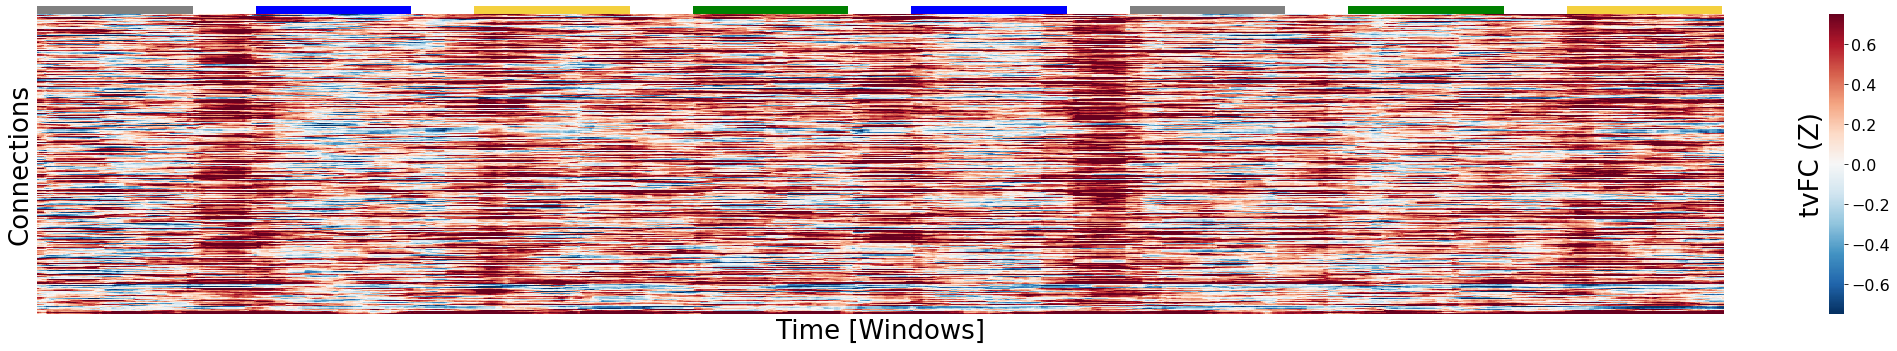

In [8]:
plt.rcParams["figure.autolayout"] = True
fig = plt.figure(figsize=(30,5))
mat = sns.heatmap(swc,cmap='RdBu_r', vmin=-0.75, vmax=0.75, xticklabels=False, yticklabels=False,cbar_kws={'label': 'tvFC (Z)'})
mat.set_xlabel('Time [Windows]', fontsize=26)
mat.set_ylabel('Connections',    fontsize=26)
for x,l in zip(tick_idxs,tick_labels):
    mat.add_patch(Rectangle((x-45, -301),  91, 300, fill=True, color=task_cmap_caps[l], lw=0, clip_on=False))
cbar = mat.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.label.set_size(26)
cbar.ax.yaxis.set_label_position('left')

***
### 2. LE STEP 1: Compute Dissimilarity Matrix

The first step of the LE algorithm is the computation of a pair-wise disimilarity metric. Here we will rely on the euclidean distance. We first compute the matrix using scipy pdist function and then place the resulting matrix into a pandas dataframe with meaninful labels

In [9]:
DS = squareform(pdist(swc.T, Distance_Function))
DS = pd.DataFrame(DS,columns=win_labels, index=win_labels)

##### 2.1 Plot the Dissimilary Matrix (Panel B)

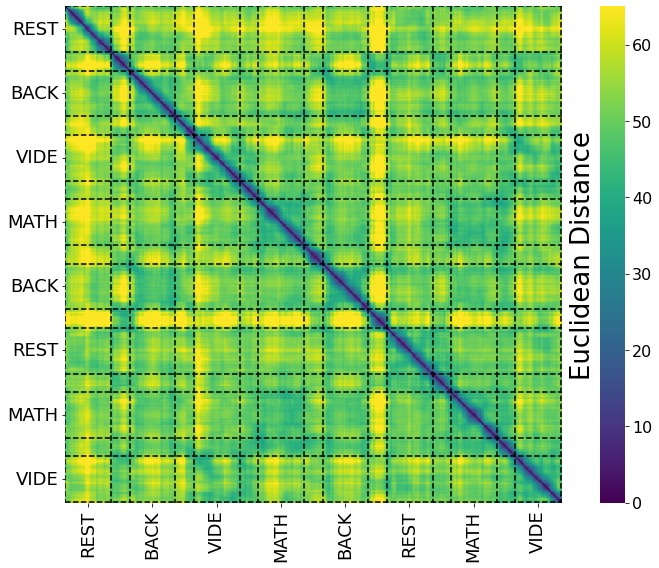

In [10]:
fig,ax = plt.subplots(1,1,figsize=(11,8))
mat = sns.heatmap(DS, cmap='viridis', ax=ax, vmin=0, vmax=65, square=True,cbar_kws={'label': 'Euclidean Distance'})
for idx in line_idxs:
    ax.plot([idx,idx],[0,DS.shape[0]],'k--')
    ax.plot([0,DS.shape[0]],[idx,idx],'k--')
ax.yaxis.set_ticks(tick_idxs);
ax.xaxis.set_ticks(tick_idxs);
ax.yaxis.set_ticklabels(tick_labels,fontsize=18);
ax.xaxis.set_ticklabels(tick_labels,fontsize=18);
cbar = mat.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.label.set_size(26)
cbar.ax.yaxis.set_label_position('left')

***
### 3. LE STEP 2: Compute the Affinity Matrix

The second step is the conversion of the disimilary matrix into an affinity matrix using the N-nearest neighbor algorithm. Here for ilustative purposes we will use knn=90.

In [11]:
W = kneighbors_graph(swc.T, knn, include_self=False, n_jobs=-1, metric=Distance_Function, mode='connectivity').toarray()

Although DS is symmetric, a call to ```kneighbors_graph``` might not necessarily render a symmetric affinity matrix becuase there is no guarantee that if node i is within the knn nearest neighbors of node j, the opposite is also true. 

To ensure that W is symmetric, we have two options:
    
* Wij = 1 if and only if i is a neighbor of j **and** j is a neighbor of i.
* Wij = 1 if and only if i is a neighbor of j **or** j is a neighbor of i.

In the original manuscript by Belkin et al., this step of the LE algorithm is described as follows: "odes i and j are connected by an edge if i is among n nearest neighbors of j or j is among n nearest neighbors of i"

This is what we implement on the next line

In [12]:
W = ((0.5 * (W + W.T)) > 0).astype(int)
W = pd.DataFrame(W,index=win_labels, columns=win_labels)
W.infer_objects();

##### 3.1. Plot the affinity matrix (Panel C)

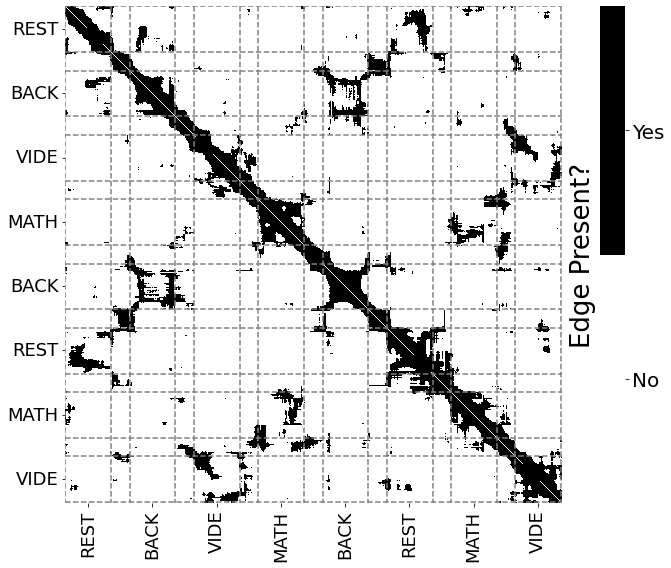

In [13]:
fig,ax = plt.subplots(1,1,figsize=(11,8))
mat = sns.heatmap(W, cmap=colors.ListedColormap(['white', 'black']), ax=ax, vmin=0, vmax=1, square=True,cbar_kws={'label': 'Edge Present?'})
for idx in line_idxs:
    ax.plot([idx,idx],[0,DS.shape[0]],'--',c='gray')
    ax.plot([0,DS.shape[0]],[idx,idx],'--',c='gray')
ax.yaxis.set_ticks(tick_idxs);
ax.xaxis.set_ticks(tick_idxs);
ax.yaxis.set_ticklabels(tick_labels,fontsize=18);
ax.xaxis.set_ticklabels(tick_labels,fontsize=18);
cbar = mat.collections[0].colorbar
cbar.ax.yaxis.set_ticks([0.25,0.75])
cbar.ax.yaxis.set_ticklabels(['No','Yes'])
cbar.ax.tick_params(labelsize=20)
cbar.ax.yaxis.label.set_size(26)
cbar.ax.yaxis.set_label_position('left')

##### 3.2. Generate Graph View of Affinity Matrix

The affinity matrix can also be thought of as a graph. Next we show this alternative view.

First, we create a networkX graph object using W

In [14]:
G   = nx.from_numpy_matrix(W.values)

Next, we compute a layout for the graph based on the spring algorithm. The same graph can be represented in many different ways. For other options, please check the layout functions in NetworkX.

In [15]:
pos = nx.layout.spring_layout(G, seed=43)

In [16]:
g_plot=hvnx.draw(G,pos,node_color='white', edge_width=0.1, edge_color='purple', node_size=150, node_edge_color='lightgray')
pn.pane.HoloViews(g_plot).save('../Resources/Figure03//G_white.png')

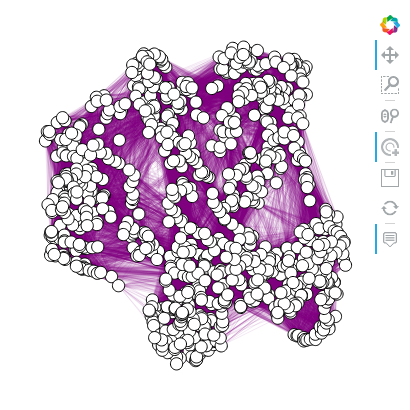

In [17]:
# This shows a static version of the figure (for github). If running the notebook yourself, simply add g_plot to a new cell
# so you can see and interact with the graph
Image("../Resources/Figure03/G_white.png")

The LE algorithm makes no use of the task information when generating the lower dimensional embedding. Yet, to visualize how the graph captures imporant aspects of the multi-task dataset, below we generate an additional view of the same graph with the same layout, but this time nodes are colored according to task instead of all of them being white color

In [18]:
# Obtain a list of unique labels, so that we can plot nodes corresponding to each task one-by-one with differnet colors
unique_win_labels = win_labels.unique()
unique_win_labels.sort()
unique_win_labels

array(['BACK', 'MATH', 'REST', 'VIDE', 'XXXX'], dtype=object)

In [19]:
g_plot = hvnx.draw(G,pos,edge_width=0.1, edge_color='purple', node_size=150)
for task in unique_win_labels:
    g_plot = g_plot * hvnx.draw_networkx_nodes(G, pos, nodelist=np.where(win_labels == task)[0].tolist(), node_color=task_cmap_caps[task], node_size=150)
g_plot
pn.pane.HoloViews(g_plot).save('../Resources/Figure03//G_colored.png')

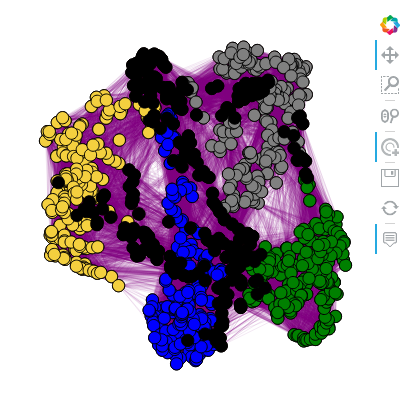

In [20]:
# This shows a static version of the figure (for github). If running the notebook yourself, simply add g_plot to a new cell
# so you can see and interact with the graph
Image("../Resources/Figure03/G_colored.png")

***
### 4. LE STEP 3: Generate the Graph Laplacian

To compute the laplacian matrix we rely on scipy function laplacian. This function can return both the laplacian and also a separate array with node degree informaiton (D).

This function can also return the normalized versions of these two structures (L and D) if normed = True. We used the normalized version for consistency with sikit-learn implementation of the LE algorithm.

In [21]:
L,D = laplacian(W.values,normed=True, return_diag=True)

The following sign change operation is performed for consistency with the scikit-learn implementation. According to the source code, the rationale for this step is:
    "We are computing the opposite of the laplacian inplace so as to spare a memory allocation of a possibly very large array"

In [22]:
L *= -1

***
### 5. LE STEP 4: Eigenvalue Decomposition

First, we generate a vector or random numbers needed by scipy eigsh function, which performs spectral decomposition of a given input matrix.

In [23]:
v0 = np.random.RandomState(42).uniform(-1,1,L.shape[0])

Becuase the first eigenvector is always discarded (as it is all ones), we always need to keep one more than the requested dimensions. In the next line we increase by one the number of dimensions being requested to accomodate for this.

In [24]:
n_components = n_components + 1
print('++ [LE]: Number of Components = %d' % n_components)

++ [LE]: Number of Components = 4


Finally, we use scipy eigsh function to perform the spectral decomposition of the Laplacian matrix

In [25]:
eigenvalues, eigenvectors = eigsh(L, k=n_components, sigma=1.0, which="LM", tol=0.0, v0=v0)

In [26]:
print('++ Eigenvalues = %s' % str(eigenvalues))

++ Eigenvalues = [-0.14244561 -0.11317635 -0.09006373  0.        ]


In [27]:
eigenvectors_df = pd.DataFrame(eigenvectors,columns=['f_{}'.format(i) for i in np.arange(n_components)])
eigenvectors_df.columns.name='Eigenvectors'
eigenvectors_df['win_labels'] = win_labels
eigenv_values_figure = eigenvectors_df.hvplot(hover_cols=['win_labels'], title='Eigenvectors', xlabel='Time [Window ID]', width=1000)
pn.pane.HoloViews(eigenv_values_figure).save('../Resources/Figure03/eigenvalues_plot.png')

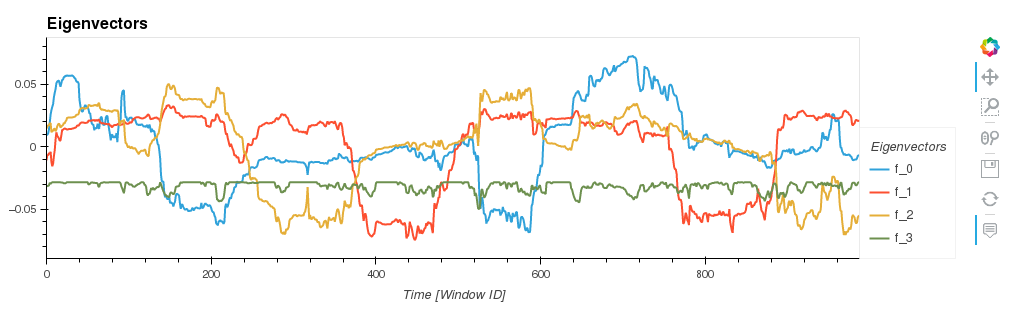

In [28]:
# This shows a static version of the figure (for github). If running the notebook yourself, simply add eigenv_values_figure to a new cell
# so you can see and interact with the graph
Image("../Resources/Figure03/eigenvalues_plot.png")

***
### 6. LE STEP 5: Compute Embedding

The last step does some final transformations (remove first eigenvalue, account for using the normalized laplacian, ensure same sign) needed to generate the final embeddings

In [29]:
embedding = eigenvectors.T[n_components::-1]

In [30]:
if norm_laplacian:
    # recover u = D^-1/2 x from the eigenvector output x
    embedding = embedding / D

In [31]:
embedding = _deterministic_vector_sign_flip(embedding)

In [32]:
embedding = embedding[1:n_components].T

In [33]:
embedding_df = pd.DataFrame(embedding,columns=['f_{}'.format(i+1) for i in np.arange(n_components-1)])
embedding_df.columns.name='Eigenvectors'
embedding_df['win_labels'] = win_labels
embedding_fig = embedding_df.hvplot(hover_cols=['win_labels'], title='Embedding', xlabel='Time [Window ID]', width=1000)
pn.pane.HoloViews(embedding_fig).save('../Resources/Figure03/embedding_plot.png')

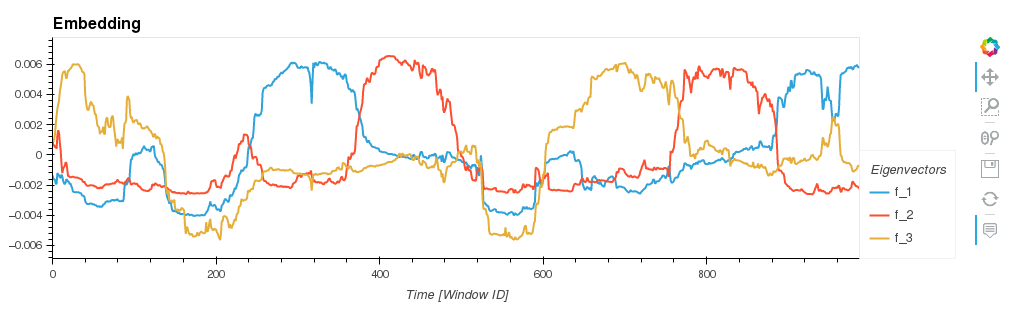

In [34]:
# This shows a static version of the figure (for github). If running the notebook yourself, simply add embedding_fig to a new cell
# so you can see and interact with the graph
Image("../Resources/Figure03/embedding_plot.png")

***
### 7. Select Dimensions and Plot (3D - Panel E)

In [35]:
LE_steps_3D         = pd.DataFrame(100*embedding,columns=['D'+str(i+1).zfill(3) for i in np.arange(3)])
LE_steps_3D['Task'] = win_labels
LE_steps_3D['size'] = 1
LE_steps_3D.head(5)

D001      D002      D003  Task  size
0 -0.136135  0.101851  0.089062  REST     1
1 -0.157151  0.062189  0.091187  REST     1
2 -0.163148  0.064061  0.101714  REST     1
3 -0.164314  0.048643  0.133984  REST     1
4 -0.193801  0.059486  0.203720  REST     1

In [36]:
fig = px.scatter_3d(LE_steps_3D,x='D001',y='D002',z='D003', width=400, height=400, color='Task', size='size', color_discrete_sequence=['gray','black','blue','yellow','green'], size_max=10)
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=1.5, y=1, z=1.5)
)
fig.update_layout(scene_camera=camera,margin=dict(l=0, r=0, b=0, t=0))
fig.update_traces(marker=dict(line=dict(width=0)))
fig.write_image('../Resources/Figure03/embedding_3d.png')

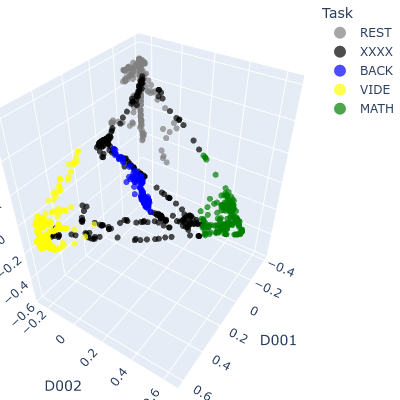

In [37]:
# This shows a static version of the figure (for github). If running the notebook yourself, simply add fig.show() to a new cell
# so you can see and interact with the graph
Image("../Resources/Figure03/embedding_3d.png")

In [38]:
embedding_2d = LE_steps_3D.hvplot.scatter(x='D001',y='D002',color='Task',cmap=task_cmap_caps,aspect='square', fontsize={'labels':20,'ticks':16})
pn.pane.HoloViews(embedding_2d).save('../Resources/Figure03/embedding_2d.png')

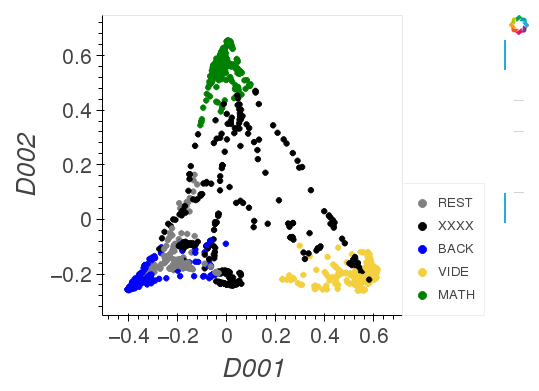

In [39]:
# This shows a static version of the figure (for github). If running the notebook yourself, simply add embedding_2d to a new cell
# so you can see and interact with the graph
Image("../Resources/Figure03/embedding_2d.png")

***
## Embedding Generated Directly using scikit-learn function SpectralEmbedding

In [40]:
from sklearn.manifold import SpectralEmbedding

In [41]:
se = SpectralEmbedding(n_components=3, n_jobs=-1, affinity='nearest_neighbors', n_neighbors=90, random_state=43)

In [42]:
LE = se.fit_transform(swc.T)

In [43]:
LE_sklearn = pd.DataFrame(100*LE, columns=['D001','D002','D003'])
LE_sklearn.infer_objects()
LE_sklearn['Task'] = win_labels.values
LE_sklearn['size'] = 1
LE_sklearn.head(5)

D001      D002      D003  Task  size
0 -0.168016  0.116295  0.146512  REST     1
1 -0.194995  0.080387  0.175781  REST     1
2 -0.198226  0.081475  0.184022  REST     1
3 -0.208809  0.062611  0.230946  REST     1
4 -0.253143  0.047862  0.318713  REST     1

In [44]:
fig = px.scatter_3d(LE_sklearn,x='D001',y='D002',z='D003', width=400, height=400, color='Task', size='size', color_discrete_sequence=['gray','black','blue','yellow','green'], size_max=10)
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=1.5, y=1, z=1.5)
)
fig.update_layout(scene_camera=camera,margin=dict(l=0, r=0, b=0, t=0))
fig.update_traces(marker=dict(line=dict(width=0)))
fig.write_image('../Resources/Figure03/embedding_3d_sklearn.png')

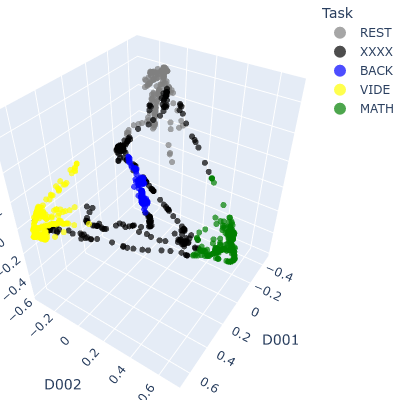

In [45]:
Image("../Resources/Figure03/embedding_3d_sklearn.png")